# QSPICE Python Files Initialization

In [81]:
import sys
import subprocess
import importlib.util

TESTED_PYTHON_VERSION = (3, 11)  # Example: tested with Python 3.11

# === Version Check ===
def check_python_version(expected_version):
    current_version = sys.version_info[:2]
    if current_version != expected_version:
        print(f"⚠️ Warning: This notebook was tested with Python {expected_version[0]}.{expected_version[1]}, "
              f"but you're running Python {current_version[0]}.{current_version[1]}.")

def check_and_install(packages):
    """
    Check if required packages are installed; install missing ones via pip.
    """
    def is_installed(pkg):
        return importlib.util.find_spec(pkg) is not None

    missing = [pkg for pkg in packages if not is_installed(pkg)]
    
    if missing:
        print(f"Installing missing packages: {missing}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
    else:
        print("✅ All required packages are installed.")

# Example usage:
#required_packages = ['jinja2', 'ipympl', 'numpy', 'pandas', 'matplotlib', 'scipy']
required_packages = ['ipympl', 'numpy', 'pandas', 'matplotlib', 'scipy']
check_python_version(TESTED_PYTHON_VERSION)
check_and_install(required_packages)

✅ All required packages are installed.


In [82]:
import os
import shutil

# Get the current working directory (where your script is running)
current_dir = os.getcwd()

# Define the source folder (QSPICE_Parser is located above the project directory)
source_folder = os.path.join(os.path.dirname(current_dir), 'QSPICE_Parser')

# Define the source file path
source_file = os.path.join(source_folder, 'QSPICE_parser.py')

# Define the destination folder within the project (subfolder called QSPICE)
destination_folder = os.path.join(current_dir, 'QSPICE')

# Define the destination file path (within the QSPICE subfolder)
destination_file = os.path.join(destination_folder, 'QSPICE_parser.py')

# Copy the file from source to destination
shutil.copy(source_file, destination_file)

'c:\\Users\\Stani\\OneDrive\\JupyterLab\\GitHub\\PowerElectronics_JupyterLab_QSPICE\\QR_Flyback\\QSPICE\\QSPICE_parser.py'

In [83]:
from QSPICE import QSPICE_parser
import importlib
import sys

# reload QSPICE/Python parser without kernel restart
importlib.reload(QSPICE_parser)

#Create PyQSPICE file for input rectifier
QSPICE_parser.parse_and_generate_script('Full_Wave_REC_P_load.qsch','QSPICE_Full_Wave_REC_P_load.py')

# Delete parser script file from QSPICE folder
os.remove(destination_file)

# Python Initialization

In [84]:
%matplotlib inline

import math
import importlib
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec

#load all QSPICE autogenerating scripts here
from QSPICE import QSPICE_Full_Wave_REC_P_load as QSPICE

from IPython.display import display, Markdown, Latex
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D

# Reload QSPICE autogenerating circuit script without kernel restart
importlib.reload(QSPICE)

# one-dimensional interpolation
def EOSS_Interp(path,file_name,VDS):
    EOSS=0
    if VDS>=0 and file_name != '':
        df = pd.read_csv(path+file_name, header=None)
        
        X=df.loc[:,0].to_numpy()
        Y=df.loc[:,1].to_numpy()

        y_interp=interp1d(X, Y)
        EOSS=y_interp(VDS)
        
    else:
        EOSS=0
        

    return EOSS

# two dimensional interpolation
def EOFF_Interp(path,file_name,VDS,ID):
    EOFF=0
    if (VDS and ID >= 0) and (file_name != ''):
        df = pd.read_csv(path+file_name, header=None)

        Y=df.iloc[1:len(df.index),0].to_numpy()

        X=df.iloc[0,1:].to_numpy()

        data=df.iloc[1:,1:].to_numpy()
   
        interp = RegularGridInterpolator((Y,X),data)
        EOFF=interp((ID,VDS))
       
    else:
        EOFF=0
    
    
    return EOFF
    
#Estimate input capacitor value based on required input ripple voltage
def Cin_estimation(Pin, freq, Vin_ripple_pp, VAC_min):
    return (Pin * 1/freq * (math.pi - 2 * math.asin((math.sqrt(2) * Vin_ripple_pp - 2 * VAC_min) / VAC_min / 2)) / math.pi / Vin_ripple_pp 
            / (2 * VAC_min * math.sqrt(2) - Vin_ripple_pp) / 2)
    
#Return estimated switching frequency
def fsw_estimation(V_DC, Vr, Pin, Lp, Coss):   
    return (-(math.sqrt(2) / math.pi * Coss ** (-0.1e1 / 0.2e1) / Vr * (-math.sqrt(2) * math.sqrt(Lp) * Pin * V_DC - math.sqrt(2) * 
            math.sqrt(Lp) * Pin * Vr + math.sqrt(2 * Lp * Pin ** 2 * V_DC ** 2 + 4 * Lp * Pin ** 2 * V_DC * Vr + 2 * Lp * Pin ** 2 
            * Vr ** 2 + 4 * math.pi * math.sqrt(Coss) * Vr ** 2 * V_DC ** 2 * math.sqrt(Lp) * Pin)) / 2 + math.sqrt(2)/ math.pi * 
            Coss ** (-0.1e1 / 0.2e1) / V_DC * (-math.sqrt(2) * math.sqrt(Lp) * Pin * V_DC - math.sqrt(2) * math.sqrt(Lp) * Pin * Vr 
            + math.sqrt(2 * Lp * Pin **2 * V_DC ** 2 + 4 * Lp * Pin ** 2 * V_DC * Vr + 2 * Lp * Pin ** 2 * Vr ** 2 + 4 * math.pi * 
            math.sqrt(Coss) * Vr ** 2 * V_DC ** 2 * math.sqrt(Lp) * Pin)) / 2 - Vr * V_DC) / math.pi * Coss ** (-0.1e1 / 0.2e1) / Vr
            / V_DC * Lp ** (-0.1e1 / 0.2e1))

#Return primary peak current
def Ip_peak(Pin, fsw, Lp):
    return math.sqrt(2*Pin/(Lp*fsw))
    
#Return primary RMS current
def Ip_RMS(Ip_pk,D):
    return Ip_pk*math.sqrt(D/3)

#Return estimated duty cycle
def D_estimation(VDC,Pin, fsw, Lp):
    return 1/VDC*math.sqrt(2*Pin*Lp*fsw)

# Input Data

In [ ]:
#Input AC values in RMS
VAC_min = 198
VAC_max = 288
VAC_nom = 230

AC_freq = 50

#Change this value such as calculated input capacitance is in agreement with rule of thumb (see section "Input Capacitor Value Recommendation (in uF)")
VDC_ripple_pp = 35
#Input capacitor ESR
Cin_ESR = 150e-3

# Nominal Output Voltage
Vout = 24
# For variable output voltage, specify Vout_max. Otherwise set Vout_max=Vout
Vout_max = 30
Pout = 115

#Estimated efficiency of DC/DC flyback converter (without losses in input REC/EMI section)
eff = 0.89
#Maximum output peak-peak voltage ripple at full load
Vout_pp = 0.1
#Output Capacitor ESR
ESR_Cout = 20e-3

# selected reflected voltage (higher value, reduce EOSS losses but increases losses in primary clamp circuit)
# Check factor kc in section "Clamped Voltage vs. Reflected Voltage Ratio (-)" and Primary clamp losses
Vr = 135
# Minimum switching frequency
fsw_min = 85e3

### Input REC Bridge Diode ####
V_rec_fwd = 1.2
r_rec_diff = 30e-3

### Input EMI Filter ###
#Additional total resistance formed by EMI components
#NTC@130degC+CM_Choke1+CM_Choke2+PFC_Choke
R_EMI = 1.27+160e-3+612e-3+0.3

### Primary Switch ####
#ONSemi NTPF450N80S3Z
#Set MOSFET Data Folder and Eoff and Eoss file names. If empty string is provided, EOFF and EOSS energy estimation is skipped and return 0 J
# Note. It assumes that EoFF energy data are obtained using standard double-pulse test method
MOS_DATA_FLD = "Data/MOSFET/NTPF450N80S3Z/"
EOFF_file_name = "Eoff_DPT_10000mOhm_27deg.csv"
EOSS_file_name = "EOSS.csv"
#EOFF_file_name = ""
#EOSS_file_name = ""

#Switch rated voltage
BVds = 800
#derating factor (switch stress is kM of switch VBR rating)
kM = 0.85
#estimated effective MOSFET Coss Capacitance + additional capacitance if provided (important for fsw estimation)
Coss = 27e-12
#Coss = 188e-12
#WC RDSon@110degC
rdson = 0.9
#Total Gate Charge
Qgate = 19.3e-9
#Gate voltage (it assumes gate voltage swing is from 0 to Vg. It is just a rough approximation)
Vg = 12

### Secondary Switch Parameters
#OnSemi MBR20200CT
Vfwd = 0.6 # set 0.001 for sync. REC
# differential resistance @125degC
r_sec_diff = 10e-3
#derating factor (diode stress is kD of diode VBR rating)
kD = 0.6

### Transformer ####
#Estimated leakage is k_leak times primary inductance
k_leak = 0.007

### Primary Clamp Snubber ###
#Estimated overshoot
#Include into Vos forward recovery of snubber diode if needed
Vos = 20
# Clamping voltage ripple  
Vclamp_pp = 25

### Secondary diode snubber ###
f_sec_ring = 20e6

### Primary Current Sense ###
Rsense = 0.195

### Secondary Current Sense ###
Rsense_sec = 12.5e-3

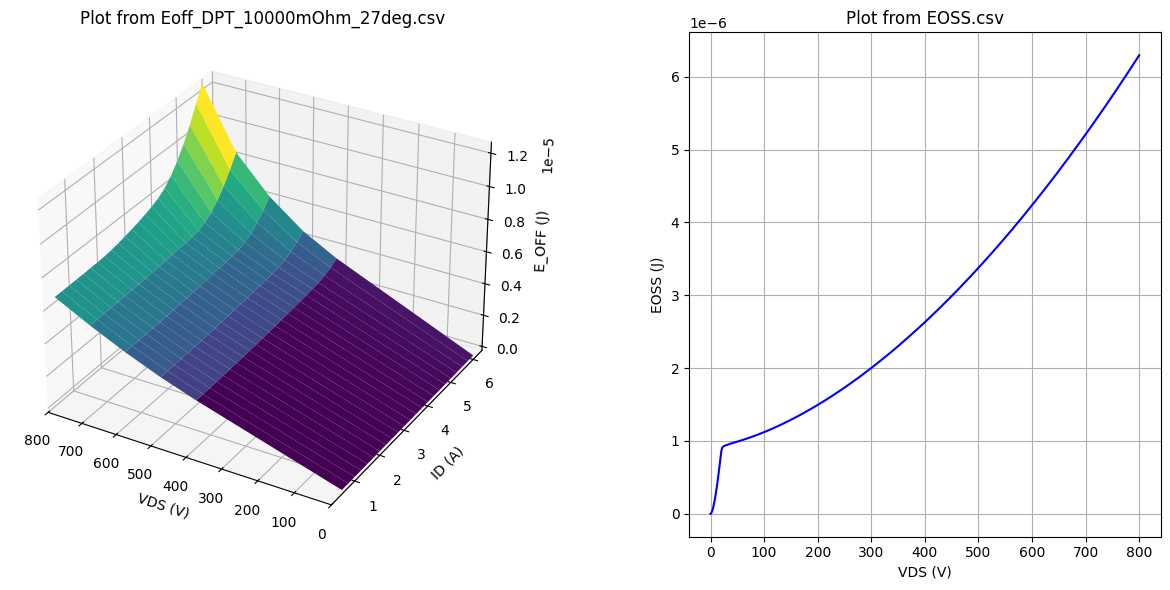

In [86]:
############### Plot Energy Data ############


if EOFF_file_name and EOSS_file_name != '':
    # Read the CSV file
    df = pd.read_csv(MOS_DATA_FLD+EOFF_file_name, header=None)

    # Extract X, Y, and Z values for the 3D plot
    X = df.iloc[0, 1:].values  # First row, except the first column
    Y = df.iloc[1:, 0].values  # First column, except the first row
    Z = df.iloc[1:, 1:].values  # The remaining values

    # Create a meshgrid for X and Y
    X, Y = np.meshgrid(X, Y)

    # Create a figure with subplots
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
    
    # 3D Plot
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')  # First subplot for 3D plot
    surf = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    ax1.set_xlabel('VDS (V)')
    ax1.set_ylabel('ID (A)')
    ax1.set_zlabel('E_OFF (J)')
    ax1.set_title('Plot from '+EOFF_file_name)
    ax1.set_xlim(X.max(), X.min())  # Reverse the direction of the X-axis
    #plt.colorbar().ax.set_ylabel('Mean Absolute Error', rotation=270, fontsize = 15, labelpad=15)
    #fig.colorbar(surf, ax=ax1,shrink=0.6, pad = 0.09)


    df2 = pd.read_csv(MOS_DATA_FLD+EOSS_file_name, header=None)

    # Extract X and Y values for the 2D plot
    # Assuming first column is X and second column is Y
    X_2D = df2.iloc[:, 0].values  # First column for X values
    Y_2D = df2.iloc[:, 1].values  # Second column for Y values

    # 2D Plot
    ax2 = fig.add_subplot(gs[0, 1])  # Second subplot for 2D plot
    ax2.plot(X_2D, Y_2D, linestyle='-', color='b')  # Customize line style and color as needed
    ax2.set_xlabel('VDS (V)')
    ax2.set_ylabel('EOSS (J)')
    ax2.set_title('Plot from '+EOSS_file_name)
    ax2.grid(True)

    # Show plot
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Pre-Calculation

## Estimated Flyback Input Power (in W)
This is estimated input power of the flyback circuit only (after the rectifier circuit)

In [87]:
Pin=Pout/eff
print(round(Pin,0))

129.0


## Input Capacitor Minimum Value Recommendation (in uF)

Rule of thumb:  
115VAC: 2uF/W  
230VAC: 1uf/W  
(85 - 265)VAC: (2 - 3) uF/W  

NOTE: Change DC ripple value such as calculated input capacitor value is in agreement with selected rule of thumb


In [88]:
Cin = Cin_estimation(Pin, AC_freq, VDC_ripple_pp, VAC_min)
print(round(Cin*1e6,0))

118.0


<span> When selecting capacitor MPN, consider tolerance, aging and ripple current.</span>

## Maximum Input DC Peak Voltage (in V)

In [89]:
VDC_max_pk=math.sqrt(2)*VAC_max
print(round(VDC_max_pk,0))

802.0


## Minimum Input DC Valley Voltage (in V)

In [90]:
VDC_min_valley = VAC_min*math.sqrt(2)-VDC_ripple_pp
print(round(VDC_min_valley,0))

245.0


## Nominal Input DC AVG Voltage (in V)

In [91]:
#ret=QR_Flyback_QSPICE_circs.QSPICE_Input_REC(VAC_nom, Cin, Pin, V_rec_fwd, r_rec_diff,AC_freq)
ret = QSPICE.QSPICE_Full_Wave_REC_P_load(Cin,Cin_ESR,AC_freq,V_rec_fwd,Pin,r_rec_diff,VAC_nom)
VDC_nom=ret[1]["VOUT_AVG"]
P_REC_Vin_nom=ret[1]["P_D_AVG"]*4
Iin_RMS_Vin_nom=ret[1]["I_AC_RMS"]
print(round(VDC_nom,0))

C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\QR_Flyback\QSPICE\Full_Wave_REC_P_load.cir

Total elapsed time: 1.29665 seconds.
QSPICE64 simulation completed successfully.
*************** END ***************
309.0


# Transformer Requirements

## Transformer Turns Ratio (Np:1)

In [92]:
N=Vr/(Vout+Vfwd)
print(round(N,2))

5.49


## Maximum Primary Inductance (in uH)

In [93]:
Lp=0.1e1 / (1 / VDC_min_valley * math.sqrt(2) * math.sqrt(fsw_min * Pin) * (VDC_min_valley / Vr + 1) + math.pi * fsw_min * math.sqrt(Coss)) ** 2
print(round(Lp*1e6,0))

328.0


# Estimated Operating Conditions

## Estimated Maximum Switching Frequency (full load) (in kHz)

In [94]:
fsw_max=fsw_estimation(VDC_max_pk, Vr, Pin, Lp, Coss)
print(round(fsw_max/1e3,0))

144.0


## Estimated Nominal Switching Frequency (full load) (in kHz)

In [95]:
fsw_nom=fsw_estimation(VDC_nom, Vr, Pin, Lp, Coss)
print(round(fsw_nom/1e3,0))

98.0


## Maximum Duty-Cycle

In [96]:
D_max=D_estimation(VDC_min_valley,Pin, fsw_min, Lp)
print(round(D_max,3))


0.346


## Minimum Duty-Cycle

In [97]:
D_min=D_estimation(VDC_max_pk,Pin, fsw_max, Lp)
print(round(D_min,3))

0.138


## Nominal Duty-Cycle

In [98]:
D_nom=D_estimation(VDC_nom,Pin, fsw_nom, Lp)
print(round(D_nom,3))

0.296


# Stress Analysis (Worst-Case Conditions)

## Estimated Primary Switch Valley Point for Nominal Output Voltage:  (in V)

### Maximum Input Voltage

In [99]:
V_valley_max=VDC_max_pk-Vr
print(round(V_valley_max,0))

667.0


### Minimum Input Voltage

In [100]:
V_valley_min=VDC_min_valley-Vr
print(round(V_valley_min,0))

110.0


### Nominal Input Voltage

In [101]:
V_valley_nom=VDC_nom-Vr
print(round(V_valley_nom,0))

174.0


## Secondary Switch VBR Requirement > (in V)
Note: Derating factor is included

In [102]:
VBR_SEC=(VDC_max_pk/N+Vout_max)/kD
print(round(VBR_SEC,0))

294.0


## AC Input RMS Current (in A)
Note: Use to properly rate the input fuse

In [103]:
#ret=QSPICE.QSPICE_Input_REC(VAC_min, Cin, Pin, V_rec_fwd, r_rec_diff,AC_freq)
ret = QSPICE.QSPICE_Full_Wave_REC_P_load(Cin,Cin_ESR,AC_freq,V_rec_fwd,Pin,r_rec_diff,VAC_min)
Iin_RMS_Vin_min=ret[1]["I_AC_RMS"]
P_REC=ret[1]["P_D_AVG"]*4
I_Cin_RMS=ret[1]["I_Cin_RMS"]

print(round(Iin_RMS_Vin_min,1))

C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\QR_Flyback\QSPICE\Full_Wave_REC_P_load.cir

Total elapsed time: 1.24126 seconds.
QSPICE64 simulation completed successfully.
*************** END ***************
1.3


## Primary Peak Current (in A)

In [104]:
Ip_pk_max=Ip_peak(Pin, fsw_min, Lp)
print(round(Ip_pk_max,1))

3.0


## Primary RMS Current (in A)

In [105]:
Ip_RMS_max=Ip_RMS(Ip_pk_max, D_max)
print(round(Ip_RMS_max,1))

1.0


## Secondary Peak Current (in A)

In [106]:
Ds=1/Vr*math.sqrt(2*Pout*Lp*fsw_min)
Ipks=(2*Pout/Vout)/Ds
print(round(Ipks,1))

16.2


## Secondary RMS Current (in A)

In [107]:
Is_RMS=Ipks*math.sqrt(Ds/3)
print(round(Is_RMS,1))

7.2


## Input Capacitor Ripple Current (in Arms)

In [108]:
print(round(I_Cin_RMS,1))

1.3


# Primary RCD Clamp Design

## Recommended Clamping Voltage (in V)

In [109]:
Vclamp=BVds*kM-Vos-VDC_max_pk
print(round(Vclamp,0))

-142.0


## Clamped Voltage vs. Reflected Voltage Ratio (-)

Note 1: The recommended range for factor kc is 1.3 to 2 (reducing kc -> higher losses in clamp circuit).  

Note 2: The worst case ratio happens for maximum output voltage.

Note 3: This might be one of the criteria for selecting suitable transformer turn ratio.

In [110]:
kc=Vclamp/((Vout_max+Vfwd)*N)
print(round(kc,1))

-0.8


## Leakage Energy (in uJ)

In [111]:
fsw_Vin_min_Vout_max=fsw_estimation(VDC_min_valley, (Vout_max+Vfwd)*N, Pin, Lp, Coss)
fsw_Vin_max_Vout_max=fsw_estimation(VDC_max_pk, (Vout_max+Vfwd)*N, Pin, Lp, Coss)
Eleak_Vmin=(0.5*Lp*k_leak*Ip_pk_max**2)
Eleak_Vmax=(0.5*Lp*k_leak*Ip_peak(Pin, fsw_max, Lp)**2)
Eleak_Vnom=(0.5*Lp*k_leak*Ip_peak(Pin, fsw_nom, Lp)**2)
Eleak_Vout_max=(0.5*Lp*k_leak*Ip_peak(Pin, fsw_Vin_min_Vout_max, Lp)**2)

In [112]:
print(fsw_Vin_max_Vout_max)
print()
print(round(Eleak_Vmin*1e6,2))
print(round(Eleak_Vmax*1e6,2))
print(round(Eleak_Vnom*1e6,2))
print(round(Eleak_Vout_max*1e6,2))

201312.9656150501

10.64
6.26
9.21
8.24


## Clamping Resistor (in kOhm)
Note: This calculation assumes maximum primary peak current based on maximum load operational condition. For the WC situation, the maximum primary peak current will be defined by PWM IC CS threshold + internal delay. When nominal Ipeak value is used, RCD Clamp should also use TVS diode to prevent Vclamp runaway under startup/fault conditions.

In [113]:
R_clp=(Vclamp*(Vclamp-(Vout_max+Vfwd)*N))/(Eleak_Vmin*fsw_min)
print(round(R_clp*1e-3,2))

48.59


## Clamping Capacitor (in pF)

In [114]:
C_clp=Vclamp/(R_clp*fsw_min*Vclamp_pp)
print(round(C_clp*1e12,0))

-1374.0


## RCD Clamp Diode Stress (in V)

In [115]:
print(round(VDC_max_pk+Vclamp,0))

660.0


# Secondary RC Snubber

## Secondary Leakage (in uH)

In [116]:
L_leak_sec=(Lp*k_leak)/N**2
print(round(L_leak_sec*1e6,5))

0.07619


## Recommended Resistor (in Ohm)

In [117]:
R_sec_snub=2*math.pi*f_sec_ring*L_leak_sec
print(round(R_sec_snub,2))

9.57


## Recommended Capacitor (in pF)

In [118]:
C_sec_snub=1/(2*math.pi*f_sec_ring*R_sec_snub)
print(round(C_sec_snub*1e12))

831


# Output Capacitor Requirements

## Ripple RMS Current (in A)

In [119]:
I_Cout_RMS=math.sqrt(Is_RMS**2-(Pout/Vout)**2)
print(round(I_Cout_RMS,1))

5.4


## Peak Current (in A)

In [120]:
I_Cout_pk=Ipks-(Pout/Vout)
print(round(I_Cout_pk,1))

11.4


## Voltage Ripple Caused by ESR (in V)

In [121]:
V_Cout_ESR_pp=Ipks*ESR_Cout

if (V_Cout_ESR_pp) > Vout_pp:
    display(Markdown('<font size="6"> <span style="color:red"> Warning: Output capacitor ESR is too high.</span></font>'))

print(round(Ipks*ESR_Cout,2))


<font size="6"> <span style="color:red"> Warning: Output capacitor ESR is too high.</span></font>

0.32


## Minimum Capacitance Value (in uF)

Note: This assumes that output capacitor ESR is 0 Ohm

In [122]:
#Cmin = Lp * Ip_pk_max ** 2 * (D_max ** 2 + 2 * D_max + 1) / (Vout_pp-V_Cout_ESR_pp) / Vout / 8
Cmin = Lp * Ip_pk_max ** 2 * (D_max ** 2 + 2 * D_max + 1) / (Vout_pp) / Vout / 8
print(round(Cmin*1e6,2))

287.02


# Losses Analysis (Worst-Case Conditions)

## Power Dissipation in Secondary Snubber (in W)

In [123]:
P_sec_snub=0.5*C_sec_snub*(Vout_max+VDC_max_pk/N)**2*fsw_Vin_max_Vout_max
print(round(P_sec_snub,2))

2.59


## Power Dissipation in Clamp (in W)

Note: For QR Flyback, snubber losses are independent on Vin. With increasing Vin, Ipeak is reduced but fsw increases thus losses remain the same

Note 2: This is theoretically estimated power dissipation, assuming 100% of the current circulating in the switch before turn-off is transferred to the diode in clamp circuit. In reality, due to the MOSFET parasitic capacitances COSS, CRSS, and transformer primary winding capacitance, part of the leakage energy is used to charge those capacitors, so the actual power dissipated in the resistor is lower.

In [124]:
P_clamp=Eleak_Vmin*fsw_min*(kc/(kc-1))
#P_clamp=Eleak_Vout_max*fsw_Vin_min_Vout_max*(kc/(kc-1))
print(round(P_clamp,2))

0.41


## Estimated Input Rectifier Losses (in W)

In [125]:
print(round(P_REC,2))

1.3


## Primary Switch Conduction Losses (in W)

In [126]:
P_FET_cond=Ip_RMS_max**2*rdson
print(round(P_FET_cond,2))

0.96


## Primary Switch Gate Losses (in mW)

Note: Qg is dramatically reduced when turning-on when VDS is low (QR or ZVS operation)

In [127]:
#check if factor 1/2 is valid or not as gate is charged/discharged in on/off thus twice per fsw
P_Gate_Vin_max=0.5*fsw_max*Qgate*Vg
print(round(P_Gate_Vin_max*1e3,2))

16.73


## Primary Switch EOSS Losses (in W)

### Maximum Input Voltage

In [128]:
P_EOSS_Vin_max=EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,V_valley_max)*fsw_max
print(round(P_EOSS_Vin_max,3))
#print(EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,V_valley_max))


0.704


### Minimum Input Voltage

In [129]:
P_EOSS_Vin_min=EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,V_valley_min)*fsw_min
print(round(P_EOSS_Vin_min,3))

0.098


### Nominal Input Voltage

In [130]:
P_EOSS_Vin_nom=EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,V_valley_nom)*fsw_nom
#round(P_EOSS_Vin_nom,3)
print(round(P_EOSS_Vin_nom,3))

0.136


## Primary Switch EOFF Losses (in W)

### Maximum Input Voltage

In [131]:
Ip_pk_min=Ip_peak(Pin, fsw_max, Lp)
P_EOFF_Vin_max=(EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,VDC_max_pk+Vclamp,Ip_pk_min)-EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,VDC_max_pk+Vr))*fsw_max
print(round(P_EOFF_Vin_max,3))

#print(Ip_pk_min)
#print(fsw_max)
#print(VDC_max_pk+Vclamp)
#print(EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,VDC_max_pk+Vr))
#print(EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,VDC_max_pk+Vclamp,Ip_pk_min))

ValueError: A value (936.859089865545) in x_new is above the interpolation range's maximum value (800).

### Minimum Input Voltage

In [ ]:
P_EOFF_Vin_min=(EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,VDC_min_valley+Vclamp,Ip_pk_max)-EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,VDC_min_valley+Vr))*fsw_min
#P_EOFF_Vin_min=(EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,VDC_min_valley+Vclamp,Ip_pk_max))*fsw_min
print(round(P_EOFF_Vin_min,3))

0.089


### Nominal Input Voltage

In [ ]:
Ip_pk_nom=Ip_peak(Pin, fsw_nom, Lp)
P_EOFF_Vin_nom=(EOFF_Interp(MOS_DATA_FLD,EOFF_file_name,VDC_nom+Vclamp,Ip_pk_nom)-EOSS_Interp(MOS_DATA_FLD,EOSS_file_name,VDC_nom+Vr))*fsw_nom
print(round(P_EOFF_Vin_nom,3))

0.11


## Secondary Switch Conduction Losses (in W)

In [ ]:
P_SW_Sec_cond=r_sec_diff*Is_RMS**2+(Pout/Vout)*Vfwd
print(round(P_SW_Sec_cond,2))

3.39


## EMI Filter DC Losses (in W)

In [ ]:
P_EMI=Iin_RMS_Vin_min**2*R_EMI
print(round(P_EMI,2))

4.26


## Primary Current Sense Resistor Losses (in W)

In [ ]:
P_RSense=Rsense*Ip_RMS_max**2
print(round(P_RSense,2))

0.21


## Secondary Current Sense Resistor Losses (in W)

In [ ]:
P_Rsense_sec=Rsense_sec*(Pout/Vout)**2
print(round(P_Rsense_sec,3))

0.287


## Estimated Flyback Losses Without Magnetic Losses (in W)

### Maximum Input Voltage

In [ ]:
P_Rsense_Vin_max = Ip_RMS(Ip_peak(Pin, fsw_max, Lp), D_min)**2*Rsense
P_FET_cond_Vin_max = Ip_RMS(Ip_pk_min, D_min)**2*rdson
P_sec_snub_Vin_max=0.5*C_sec_snub*(Vout+VDC_max_pk/N)**2*fsw_max

Ds=1/Vr*math.sqrt(2*Pout*Lp*fsw_max)
Ipks=(2*Pout/Vout)/Ds
Is_RMS_Vin_max=Ipks*math.sqrt(Ds/3)
P_SW_Sec_cond_Vin_max=r_sec_diff*Is_RMS_Vin_max**2+(Pout/Vout)*Vfwd

#print(round(P_Rsense_Vin_max,3))
#print(round(P_FET_cond_Vin_max,3))
#print(round(P_SW_Sec_cond_Vin_max,3))
#print(round(P_EOSS_Vin_max,3))
#print(round(P_EOFF_Vin_max,3))

Ptot_flyback_Vin_max=P_Rsense_Vin_max+P_Rsense_sec+P_clamp+P_SW_Sec_cond_Vin_max+P_FET_cond_Vin_max+P_EOSS_Vin_max+P_EOFF_Vin_max+P_Gate_Vin_max+P_sec_snub_Vin_max
print(round(Ptot_flyback_Vin_max,2))

#P_Gate_Vin_max=0.5*fsw_max*Qgate*Vg

7.73


### Minimum Input Voltage

In [ ]:
P_sec_snub_Vin_min=0.5*C_sec_snub*(Vout+VDC_min_valley/N)**2*fsw_min
P_Gate_Vin_min=0.5*fsw_min*Qgate*Vg
Ptot_flyback_Vin_min=P_RSense+P_Rsense_sec+P_clamp+P_SW_Sec_cond+P_FET_cond+P_EOSS_Vin_min+P_EOFF_Vin_min+P_Gate_Vin_min+P_sec_snub_Vin_min
print(round(Ptot_flyback_Vin_min,2))

7.91


### Nominal Input Voltage

In [ ]:
P_Gate_Vin_nom=0.5*fsw_nom*Qgate*Vg
P_Rsense_Vin_nom = Ip_RMS(Ip_peak(Pin, fsw_nom, Lp), D_nom)**2*Rsense
P_FET_cond_Vin_nom = Ip_RMS(Ip_pk_nom, D_nom)**2*rdson
P_sec_snub_Vin_nom=0.5*C_sec_snub*(Vout+VDC_nom/N)**2*fsw_nom

Ds=1/Vr*math.sqrt(2*Pout*Lp*fsw_nom)
Ipks=(2*Pout/Vout)/Ds
Is_RMS_Vin_nom=Ipks*math.sqrt(Ds/3)
P_SW_Sec_cond_Vin_nom=r_sec_diff*Is_RMS_Vin_nom**2+(Pout/Vout)*Vfwd

Ptot_flyback_Vin_nom=P_Rsense_Vin_nom+P_Rsense_sec+P_clamp+P_SW_Sec_cond_Vin_nom+P_FET_cond_Vin_nom+P_EOSS_Vin_nom+P_EOFF_Vin_nom+P_Gate_Vin_nom+P_sec_snub_Vin_nom
print(round(Ptot_flyback_Vin_nom,2))

7.72


# Estimated Total Converter Losses Without Magnetic Losses (in W)

### Maximum Input Voltage

In [ ]:
#ret=QR_Flyback_QSPICE_circs.QSPICE_Input_REC(VAC_max, Cin, Pin, V_rec_fwd, r_rec_diff,AC_freq)
ret = QSPICE.QSPICE_Full_Wave_REC_P_load(Cin,Cin_ESR,AC_freq,V_rec_fwd,Pin,r_rec_diff,VAC_max)
Iin_RMS_Vin_max=ret[1]["I_AC_RMS"]

P_REC_Vin_max=ret[1]["P_D_AVG"]*4
P_EMI_Vin_max=R_EMI*Iin_RMS_Vin_max**2

P_Tot_Vin_max = P_REC_Vin_max+P_EMI_Vin_max+Ptot_flyback_Vin_max
print(round(P_Tot_Vin_max,2))


C:\Users\Stani\OneDrive\JupyterLab\GitHub\PowerElectronics_JupyterLab_QSPICE\QR_Flyback\QSPICE\Full_Wave_REC_P_load.cir

Total elapsed time: 1.23846 seconds.
QSPICE64 simulation completed successfully.
*************** END ***************
11.35


### Minimum Input Voltage

In [ ]:
P_Tot_Vin_min = P_REC+P_EMI+Ptot_flyback_Vin_min
print(round(P_Tot_Vin_min,2))

13.46


### Nominal Input Voltage

In [ ]:
P_EMI_Vin_nom=R_EMI*Iin_RMS_Vin_nom**2

P_Tot_Vin_nom = P_REC_Vin_nom+P_EMI_Vin_nom+Ptot_flyback_Vin_nom
print(round(P_Tot_Vin_nom,2))

12.39


# Estimated Flyback Efficiency Without Magnetics (in %)

In [ ]:
eff_calc_Vin_max=Pout/(Pout+Ptot_flyback_Vin_max)
eff_calc_Vin_min=Pout/(Pout+Ptot_flyback_Vin_min)
eff_calc_Vin_nom=Pout/(Pout+Ptot_flyback_Vin_nom)

print("Maximum Input Voltage: ",round(eff_calc_Vin_max*100,1))
print("Minimum Input Voltage: ",round(eff_calc_Vin_min*100,1))
print("Nominal Input Voltage: ",round(eff_calc_Vin_nom*100,1))

Maximum Input Voltage:  93.7
Minimum Input Voltage:  93.6
Nominal Input Voltage:  93.7


# Estimated Total Converter Efficiency Without Magnetics (in %)

In [ ]:
eff_tot_calc_Vin_max=Pout/(Pout+P_Tot_Vin_max)
eff_tot_calc_Vin_min=Pout/(Pout+P_Tot_Vin_min)
eff_tot_calc_Vin_nom=Pout/(Pout+P_Tot_Vin_nom)

print("Maximum Input Voltage: ",round(eff_tot_calc_Vin_max*100,1))
print("Minimum Input Voltage: ",round(eff_tot_calc_Vin_min*100,1))
print("Nominal Input Voltage: ",round(eff_tot_calc_Vin_nom*100,1))

Maximum Input Voltage:  91.0
Minimum Input Voltage:  89.5
Nominal Input Voltage:  90.3


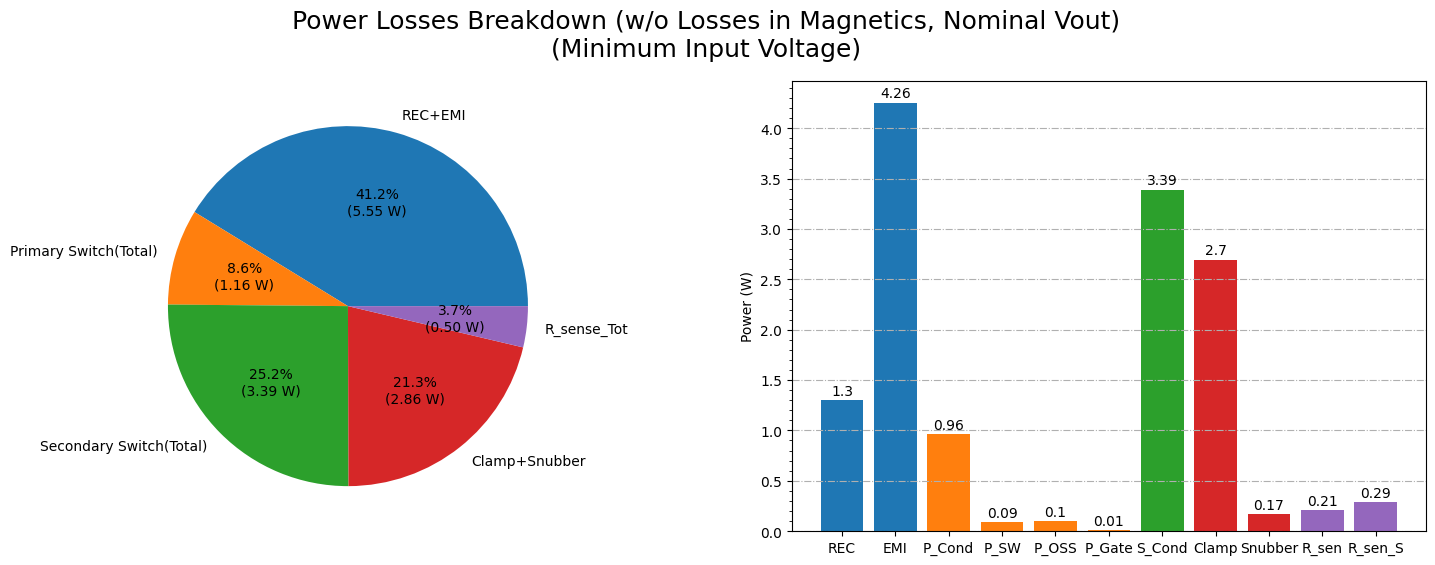

In [ ]:
labels_Ploss= 'REC+EMI', 'Primary Switch(Total)', 'Secondary Switch(Total)', 'Clamp+Snubber','R_sense_Tot'
data_Ploss = [P_REC+P_EMI, P_FET_cond+P_EOSS_Vin_min+P_EOFF_Vin_min+P_Gate_Vin_min, P_SW_Sec_cond, P_clamp+P_sec_snub_Vin_min, P_RSense+P_Rsense_sec]

labels_Ploss_Bar= 'REC','EMI', 'P_Cond','P_SW','P_OSS', 'P_Gate', 'S_Cond', 'Clamp','Snubber','R_sen','R_sen_S'
data_Ploss_Bar = [P_REC, P_EMI,P_FET_cond,P_EOFF_Vin_min,P_EOSS_Vin_min,P_Gate_Vin_min,P_SW_Sec_cond,P_clamp,P_sec_snub_Vin_min,P_RSense,P_Rsense_sec]

#labels_bar= 'DC/DC', 'Total'
#data_bar = [round((Pout/(Pout+Ptot_flyback_Vin_min))*100,1), round((Pout/(Pout+Ptot))*100,1)]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:orange','tab:orange','tab:green','tab:red', 'tab:red','tab:purple','tab:purple']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
#fig, ax1 = plt.subplots()
fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics, Nominal Vout)'+'\n'+'(Minimum Input Voltage)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(top=0.86)

plt.show()

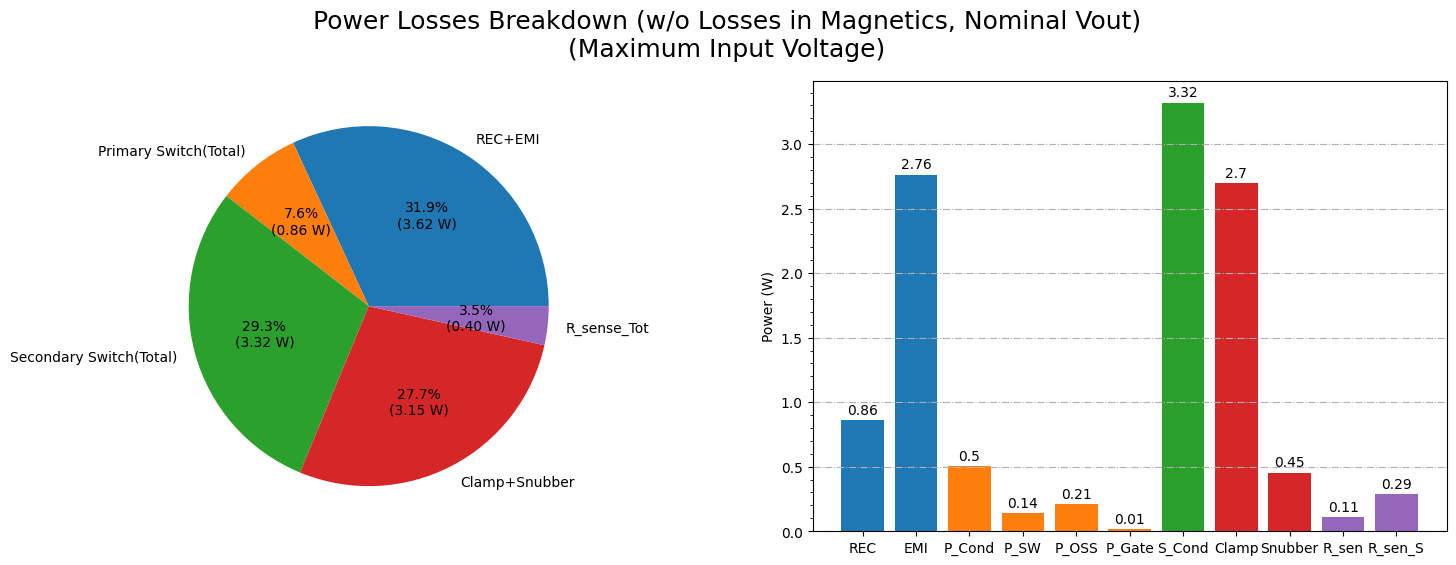

In [ ]:
labels_Ploss= 'REC+EMI', 'Primary Switch(Total)', 'Secondary Switch(Total)', 'Clamp+Snubber','R_sense_Tot'
data_Ploss = [P_REC_Vin_max+P_EMI_Vin_max, P_FET_cond_Vin_max+P_EOSS_Vin_max+P_EOFF_Vin_max+P_Gate_Vin_max, P_SW_Sec_cond_Vin_max, P_clamp+P_sec_snub_Vin_max, P_Rsense_Vin_max+P_Rsense_sec]

#Ptot_flyback_Vin_max=P_Rsense_Vin_max+P_clamp+P_SW_Sec_cond_Vin_max+P_FET_cond_Vin_max+P_EOSS_Vin_max+P_EOFF_Vin_max

labels_Ploss_Bar= 'REC','EMI', 'P_Cond','P_SW','P_OSS', 'P_Gate', 'S_Cond', 'Clamp', 'Snubber','R_sen','R_sen_S'
data_Ploss_Bar = [P_REC_Vin_max, P_EMI_Vin_max, P_FET_cond_Vin_max,P_EOFF_Vin_max,P_EOSS_Vin_max,P_Gate_Vin_max,P_SW_Sec_cond_Vin_max,P_clamp,P_sec_snub_Vin_max,P_Rsense_Vin_max,P_Rsense_sec]

#labels_bar= 'DC/DC', 'Total'
#data_bar = [round((Pout/(Pout+Ptot_flyback_Vin_min))*100,1), round((Pout/(Pout+Ptot))*100,1)]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange','tab:green','tab:red','tab:red','tab:purple','tab:purple']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
#fig, ax1 = plt.subplots()
fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics, Nominal Vout)'+'\n'+'(Maximum Input Voltage)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(top=0.86)

plt.show()

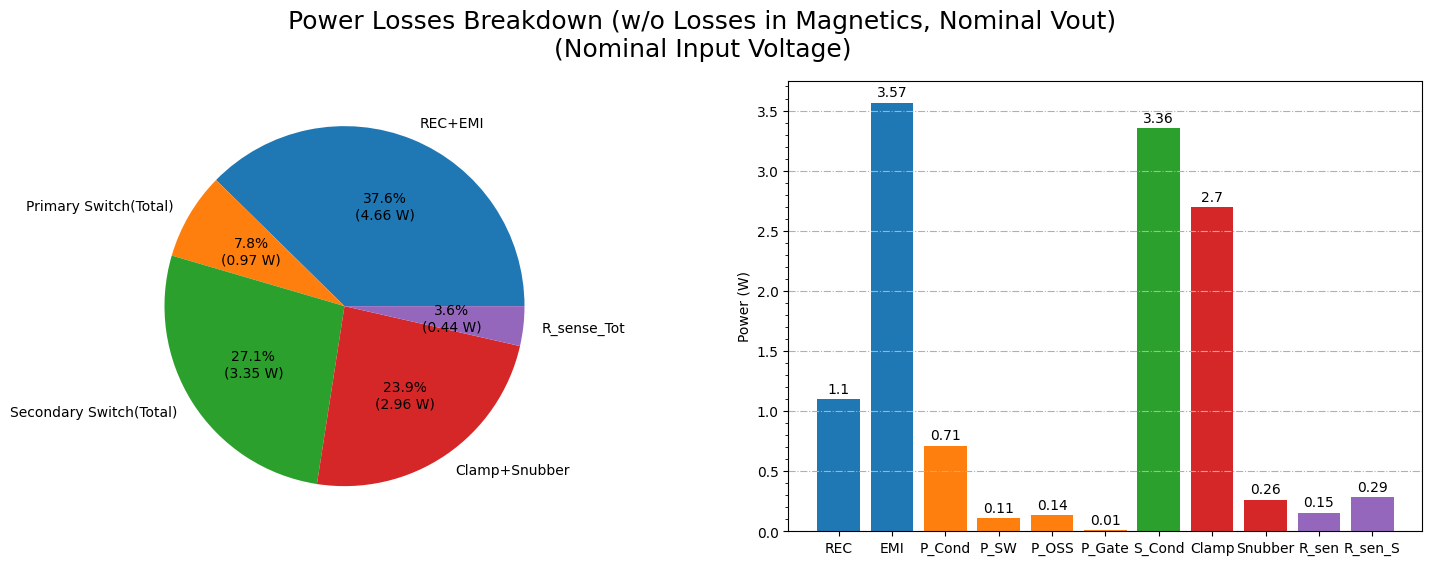

In [ ]:
labels_Ploss= 'REC+EMI', 'Primary Switch(Total)', 'Secondary Switch(Total)', 'Clamp+Snubber','R_sense_Tot'
data_Ploss = [P_REC_Vin_nom+P_EMI_Vin_nom, P_FET_cond_Vin_nom+P_EOSS_Vin_nom+P_EOFF_Vin_nom+P_Gate_Vin_nom, P_SW_Sec_cond_Vin_nom, P_clamp+P_sec_snub_Vin_nom, P_Rsense_Vin_nom+P_Rsense_sec]

#Ptot_flyback_Vin_max=P_Rsense_Vin_max+P_clamp+P_SW_Sec_cond_Vin_max+P_FET_cond_Vin_max+P_EOSS_Vin_max+P_EOFF_Vin_max

labels_Ploss_Bar= 'REC','EMI', 'P_Cond','P_SW','P_OSS','P_Gate', 'S_Cond', 'Clamp','Snubber','R_sen','R_sen_S'
data_Ploss_Bar = [P_REC_Vin_nom, P_EMI_Vin_nom, P_FET_cond_Vin_nom,P_EOFF_Vin_nom,P_EOSS_Vin_nom,P_Gate_Vin_nom,P_SW_Sec_cond_Vin_nom,P_clamp,P_sec_snub_Vin_nom,P_Rsense_Vin_nom,P_Rsense_sec]

#labels_bar= 'DC/DC', 'Total'
#data_bar = [round((Pout/(Pout+Ptot_flyback_Vin_min))*100,1), round((Pout/(Pout+Ptot))*100,1)]

#bar_labels = ['red', 'blue', '_red', 'orange','green']
bar_colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange','tab:green','tab:red','tab:red','tab:purple','tab:purple']

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = round(pct*total/100,3)
            return '{:.1f}%\n({v:.2f} W)'.format(pct, v=val)
        return my_format

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+0.05, round(y[i],2), ha = 'center')
        

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
#fig, ax1 = plt.subplots()
fig.suptitle('Power Losses Breakdown (w/o Losses in Magnetics, Nominal Vout)'+'\n'+'(Nominal Input Voltage)',fontsize=18)
ax1.pie(data_Ploss, labels=labels_Ploss, autopct=autopct_format(data_Ploss))

ax2.bar(labels_Ploss_Bar, data_Ploss_Bar,color=bar_colors)
ax2.grid(True, linestyle='-.',axis='y')
ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
ax2.set_ylabel('Power (W)')
addlabels(labels_Ploss_Bar,data_Ploss_Bar)

fig.subplots_adjust(top=0.86)

plt.show()

In [ ]:
if eff > min(eff_calc_Vin_max, eff_calc_Vin_min, eff_calc_Vin_nom):
    display(Markdown('<font size="6"> <span style="color:red"> Warning: User estimated efficiency is bigger than calculated. The results are underestimated.</span></font>'))

    
